In [22]:
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Mon Mar 22 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.13.0

numpy     : 1.20.1
sys       : 3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]
pandas    : 1.2.2
matplotlib: 3.1.2

Watermark: 2.2.0



In [3]:
pd.set_option("max_columns", None)
pd.set_option("max_rows", None)

In [4]:
# I think that it is more pythonic to use lower case variable names. 
tr = pd.read_csv('./Data/Train-1542865627584.csv')
tr_bene = pd.read_csv('./Data/Train_Beneficiarydata-1542865627584.csv')
tr_in = pd.read_csv('./Data/Train_Inpatientdata-1542865627584.csv')
tr_out = pd.read_csv('./Data/Train_Outpatientdata-1542865627584.csv')

In [5]:
# combine data frames to one (assume that they are indeed combinable)

# intermediate data frome of in and out patient
dfs = {'in': tr_in, 'out' : tr_out}
tr_intermediate = pd.concat(dfs)

# collect dataframe info and drop the numeric index
tr_intermediate.reset_index(inplace=True)
tr_intermediate = tr_intermediate.drop('level_1', axis=1)

# intermediate data frame with beneficary
tr_inter_bene = pd.merge(tr_intermediate, tr_bene, how='inner', 
                left_on = ['BeneID'], right_on = ['BeneID'])


# all training data
tr_all = pd.merge(tr,tr_inter_bene,on='Provider')

In [6]:
# things to recode
y_n = { 'Yes':1, 'No':0 }
in_out = { 'in':1, 'out':0 }
renal = { 'Y':1, '0':0 }


# grab date columns
date_cols = [c for c in tr_all if c.endswith('Dt')] + ['DOB', 'DOD']



# replace with codes
tr_all = tr_all.replace({ 'PotentialFraud': y_n, 
                          'level_0':in_out, 
                          'RenalDiseaseIndicator':renal
                        })

# format dates
tr_all[date_cols] = tr_all[date_cols].apply(pd.to_datetime)

In [7]:
#grab chronic condition columns change [2,1] to [1,0]
chron_con_cols = [c for c in tr_all if c.startswith('ChronicCond_')] +['Gender']

for c in chron_con_cols:
    tr_all[c] = tr_all[c]-1


In [8]:
# calculate meaningful info from dates
tr_all['claim_dur'] = (tr_all['ClaimEndDt'] - tr_all['ClaimStartDt']).dt.days
tr_all['admiss_dur'] = (tr_all['DischargeDt'] - tr_all['AdmissionDt']).dt.days
tr_all['age_at_claim'] = tr_all['ClaimStartDt'].dt.year - tr_all['DOB'].dt.year
tr_all['is_dead'] = [0 if pd.isnull(x) else 1 for x in tr_all['DOD']]

In [9]:
tr_all_dropna = tr_all[['PotentialFraud','level_0', 'InscClaimAmtReimbursed',
       'DeductibleAmtPaid','Gender', 'Race', 'RenalDiseaseIndicator', 'State', 'County',
       'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'ChronicCond_Alzheimer',
       'ChronicCond_Heartfailure', 'ChronicCond_KidneyDisease',
       'ChronicCond_Cancer', 'ChronicCond_ObstrPulmonary',
       'ChronicCond_Depression', 'ChronicCond_Diabetes',
       'ChronicCond_IschemicHeart', 'ChronicCond_Osteoporasis',
       'ChronicCond_rheumatoidarthritis', 'ChronicCond_stroke',
       'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt',
       'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'claim_dur',
       'admiss_dur', 'age_at_claim', 'is_dead']].dropna()

In [12]:
# X and y
X = tr_all_dropna.drop(['PotentialFraud'], axis=1)
y = tr_all_dropna['PotentialFraud']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [17]:
model = LogisticRegression(C=0.01, penalty='l1', tol=0.01, solver='saga')
model.fit(X_train,y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.01, verbose=0,
                   warm_start=False)

In [28]:
pred = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, pred).ravel()
print('true neg: ', tn)
print('true pos: ', tp)
print('false neg: ', fn)
print('false pos: ', fp)

true neg:  73
true pos:  7518
false neg:  54
false pos:  5415


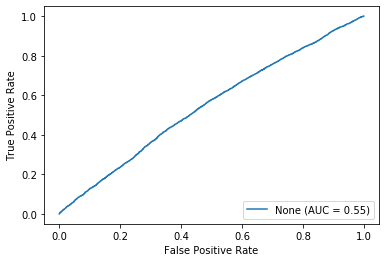

In [43]:
y_score = model.decision_function(X_test)
fpr, tpr, _ = metrics.roc_curve(y_test, y_score, pos_label=model.classes_[1])
auc = metrics.roc_auc_score(y_test, y_score)
roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=None).plot()

In [39]:
y_score

array([0.23512264, 0.36187307, 0.47320352, ..., 0.16742021, 0.31158057,
       0.26994734])